In [11]:
import numpy as np

from tensorflow import data as tfd

from keras.utils import image_dataset_from_directory
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import (
    EarlyStopping,
    ReduceLROnPlateau
)
from keras.layers import (
    Rescaling,
    Conv2D,
    MaxPooling2D,
    Dropout,
    Flatten,
    Dense,
)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay


In [12]:
prePath = "../Data/PreprocessedAlexNet"

shape = (227, 227, 3)
batchSize = 32
validationSplit = 0.2
seed = 123
colorMode = "rgb"

optimizer = Adam(learning_rate=0.0001)
loss = "binary_crossentropy"
metrics = ["accuracy"]

epochs = 100

In [17]:
trainingDS = image_dataset_from_directory(
    prePath,
    labels="inferred",
    label_mode="binary",
    subset="training",
    image_size=shape[0:2],
    color_mode=colorMode,
    batch_size=batchSize,    
    validation_split=validationSplit,
    seed=seed
)

validationDS = image_dataset_from_directory(
    prePath,
    labels="inferred",
    label_mode="binary",
    subset="validation",
    image_size=shape[0:2],
    color_mode=colorMode,
    batch_size=batchSize,    
    validation_split=validationSplit,
    seed=seed
)

sampleSize = 560
testDSBatchNumber = int(sampleSize // batchSize * (validationSplit / 2))

testDS = validationDS.take(testDSBatchNumber)
validationDS = validationDS.skip(testDSBatchNumber)

print('Batches for training -->', trainingDS.cardinality())
print('Batches for validating -->', validationDS.cardinality())
print('Batches for testing -->', testDS.cardinality())

Found 560 files belonging to 2 classes.
Using 448 files for training.
Found 560 files belonging to 2 classes.
Using 112 files for validation.
Batches for training --> tf.Tensor(14, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(3, shape=(), dtype=int64)
Batches for testing --> tf.Tensor(1, shape=(), dtype=int64)


In [18]:
callbacks = [
    EarlyStopping(
        monitor="val_accuracy",
        patience=5,
        verbose=1,
        mode="auto",
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_accuracy",
        factor=0.2,
        patience=2,
        verbose=1,
        mode="auto",
        min_lr=0.000005
    )]

model = Sequential(
    [
        Rescaling(1.0 / 255, input_shape=shape),
        Conv2D(96, 11, strides=(4, 4),
               padding="valid", activation="ReLU"),
        MaxPooling2D(pool_size=(3, 3), strides=(
            2, 2), padding="valid"),
        Conv2D(256, 5, strides=(1, 1),
               padding="same", activation="ReLU"),
        MaxPooling2D(pool_size=(3, 3), strides=(
            2, 2), padding="valid"),
        Conv2D(384, 3, strides=(1, 1),
               padding="same", activation="ReLU"),
        Conv2D(384, 3, strides=(1, 1),
               padding="same", activation="ReLU"),
        Conv2D(256, 3, strides=(1, 1),
               padding="same", activation="ReLU"),
        MaxPooling2D(pool_size=(3, 3), strides=(
            2, 2), padding="valid"),
        Dropout(0.5),
        Flatten(),
        Dense(units=4096, activation="ReLU"),
        Dropout(0.5),
        Dense(units=4096, activation="ReLU"),
        Dense(1, activation="sigmoid"),
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 227, 227, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 384)      

In [19]:
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics,
)
history = model.fit(
    trainingDS,
    validation_data=validationDS,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/100
14/14 [==============================] - 38s 3s/step - loss: 0.4862 - accuracy: 0.8348 - val_loss: 0.4233 - val_accuracy: 0.8625 - lr: 1.0000e-04
Epoch 2/100
14/14 [==============================] - 59s 4s/step - loss: 0.4571 - accuracy: 0.8482 - val_loss: 0.5026 - val_accuracy: 0.8375 - lr: 1.0000e-04
Epoch 3/100
14/14 [==============================] - ETA: 0s - loss: 0.4649 - accuracy: 0.8482
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
14/14 [==============================] - 65s 5s/step - loss: 0.4649 - accuracy: 0.8482 - val_loss: 0.4812 - val_accuracy: 0.8250 - lr: 1.0000e-04
Epoch 4/100
14/14 [==============================] - 77s 6s/step - loss: 0.4447 - accuracy: 0.8482 - val_loss: 0.3933 - val_accuracy: 0.8750 - lr: 2.0000e-05
Epoch 5/100
14/14 [==============================] - 68s 5s/step - loss: 0.4406 - accuracy: 0.8482 - val_loss: 0.3924 - val_accuracy: 0.8750 - lr: 2.0000e-05
Epoch 6/100
14/14 [==============================]

In [24]:
predictions = model.predict(testDS)
predArray = np.array((1 * (predictions > 0.5))).ravel()
trueArray = np.array(list(testDS.take(-1))[-1][-1]).ravel().astype(int)

print(f"Predicted values: {predArray}")
print(f"True values:      {trueArray}")

1/1 [==============================] - 1s 839ms/step
Predicted values: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
True values:      [0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1]


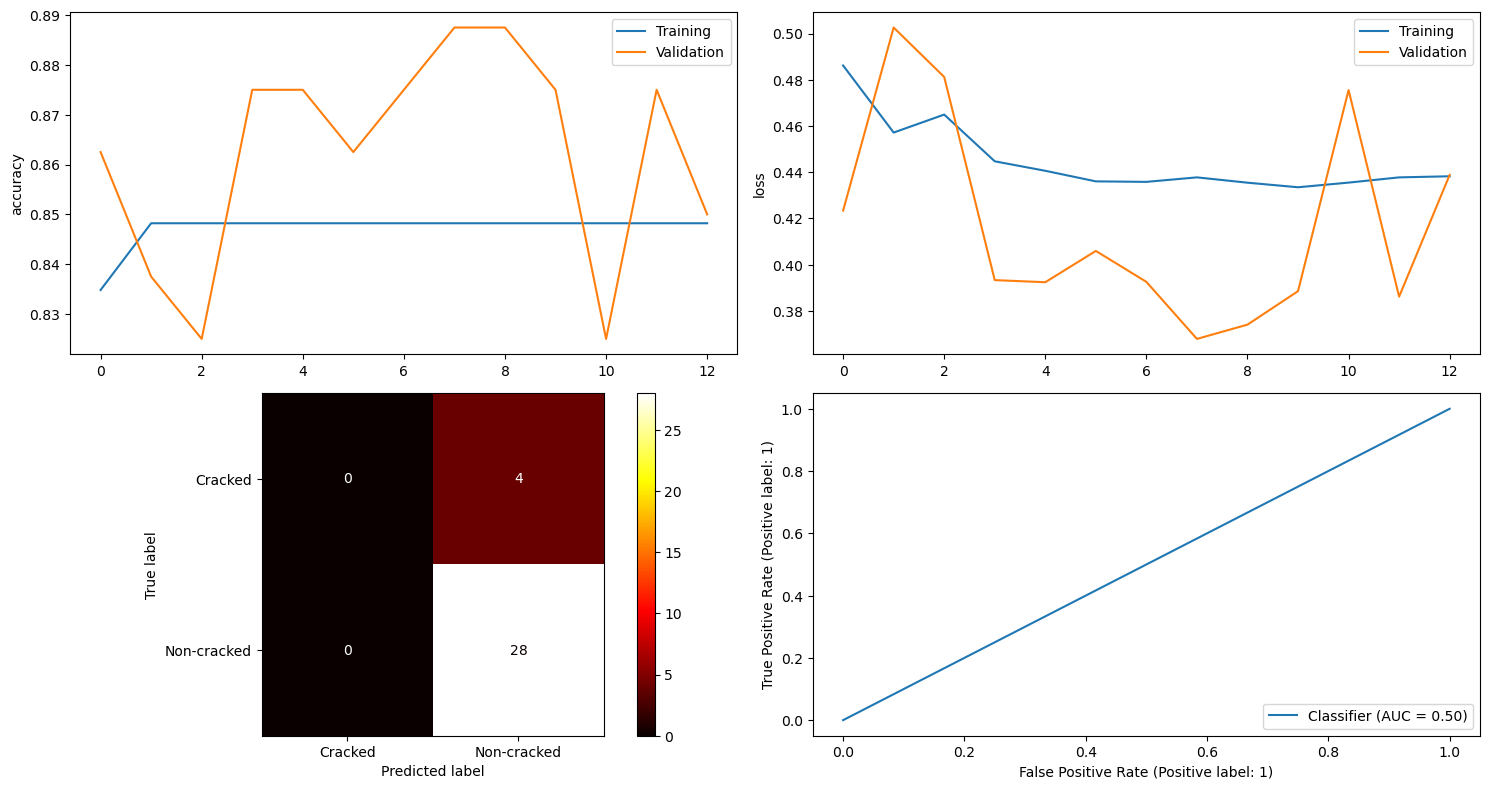

In [27]:
epochsTaken = len(history.history["accuracy"])

_, ax = plt.subplots(2, 2, figsize=(15, 8), tight_layout=True)
sns.lineplot(
    x=np.arange(epochsTaken),
    y="accuracy",
    data=history.history,
    ax=ax[0, 0],
    label="Training",
)
sns.lineplot(
    x=np.arange(epochsTaken),
    y="val_accuracy",
    data=history.history,
    ax=ax[0, 0],
    label="Validation",
)
sns.lineplot(
    x=np.arange(epochsTaken),
    y="loss",
    data=history.history,
    ax=ax[0, 1],
    label="Training",
)
sns.lineplot(
    x=np.arange(epochsTaken),
    y="val_loss",
    data=history.history,
    ax=ax[0, 1],
    label="Validation",
)
ConfusionMatrixDisplay.from_predictions(
            trueArray,
            predArray,
            display_labels=trainingDS.class_names,
            ax=ax[1, 0],
            cmap="hot",
            colorbar=True,
)
RocCurveDisplay.from_predictions(
    trueArray,
    predArray,
    ax=ax[1, 1])
       
plt.show()
